# **Plotting straight lines**


Data was aggregated by the <a href="https://colab.research.google.com/drive/1nPgD7U6zJIHLGlonTdbDhq3ApHCcMFCM?usp=sharing">OT_Defending_The_Edge_Metric_Aggregation.ipynb</a> notebook file


to plot plays, use defending-the-edge-plots.ipynb


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from functools import partial
from matplotlib.animation import writers
import os
import os.path
from os import path



#%matplotlib inline

In [2]:
# Import from GoogleDrive

from google.colab import drive
drive.mount('/content/gdrive')
os.chdir("//content/gdrive/MyDrive/nfl-big-data-bowl-2023/")

data_dir = "/content/gdrive/My Drive/nfl-big-data-bowl-2023/"
save_dir = "/content/gdrive/My Drive/nfl-big-data-bowl-2023/charts/"
lines_plots_dir = "/content/gdrive/My Drive/nfl-big-data-bowl-2023/lines_plots/"
#if on kaggle
#data_dir = "/kaggle/input/nfl-big-data-bowl-2023/"

'''
data_dir = "../input/metrics-databowl-v2/original_databowl.db"
OUTPUT_DIR = './'
'''

Mounted at /content/gdrive


'\ndata_dir = "../input/metrics-databowl-v2/original_databowl.db"\nOUTPUT_DIR = \'./\'\n'

In [3]:
import sqlite3

# Create a SQL connection to a local SQLite database
#con = sqlite3.connect(data_dir + "original_databowl.db")
#con = sqlite3.connect(data_dir + "35_databowl.db")
con = sqlite3.connect(data_dir + "databowl.db")
#con = sqlite3.connect(data_dir + "45_databowl.db")
#con = sqlite3.connect(data_dir + "full_databowl.db")



In [ ]:
!ls
!ls lines_plots
#!rm lines_plots/*

 charts				  play_predictor_3.csv
 combines.csv			  play_predictor_4.csv
'Copy of original_databowl.db'	  play_predictor_5.csv
 databowl_additional_tables.sql   play_predictor_6.csv
 databowl.db			  play_predictor_7.csv
 games.csv			  play_predictor_8.csv
 lines_metrics.sql		  play_predictor_data.csv
 lines_plots			  plays.csv
 models				  unwritable_databowl.db
 my_filengs_2016_passing.csv	  week1.csv
 ngs_2016_passing.csv.gz	  week2.csv
 ngs-data-main			  week3.csv
 old_databowl.db		  week4.csv
 original_databowl.db		  week5.csv
 pffScoutingData.csv		  week6.csv
 players.csv			  week7.csv
 play_predictor_1.csv		  week8.csv
 play_predictor_2.csv		  xgbcl_model.pkl


# **Measuring Euclidean Distance**

the Euclidean distance between two points in Euclidean space is the length of a line segment between the two points.

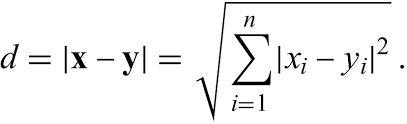



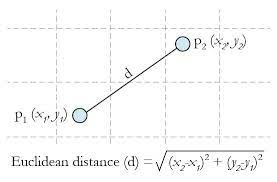

I use the euclidean distance between QB and OT, and for QB and DE as a metric for pressure on the Quarterback and for other metrics, for instance 'time on block' of OT on DE, measuring the (d) over a time series. Block Cohesion also ustilized Euclidean distance (d). 

In [4]:
TIME_CONSTANT = 40 #defines the length of time to analyze a play 1 sec = 10

# **Sample Plot of Straight Lines, Predicted Position and Actual Position of DE**

In [5]:
def game_frames(reference1_id, reference2_id, game_id, play_id):

    sql = """
           select * from frame_metrics as fm WHERE fm.reference1_id = """ + str(reference1_id) + """ 
           AND  fm.reference2_id = """ + str(reference2_id) + """ 
           AND  fm.gameId = """ + str(game_id) + """ 
           AND  fm.playId = """ + str(play_id) + """ 
    """  
    query = pd.read_sql_query(sql, con)
    return query

def ids_for_frames(game_id, play_id):

    sql = """
           select DISTINCT reference1_id, reference2_id, ref1_role, ref2_role from frame_metrics as fm WHERE fm.gameId = """ + str(game_id) + """ 
           AND  fm.playId = """ + str(play_id) + """ 
    """  
    query = pd.read_sql_query(sql, con)
    return query

def defender_for_play(nfl_id, game_id, play_id):

    sql = """
           select DISTINCT reference2_id from frame_metrics as fm WHERE fm.reference1_id = """ + str(nfl_id) + """ 
           AND fm.playId = """ + str(play_id) + """  
           AND fm.gameId = """ + str(game_id) + """
    """  
    query = pd.read_sql_query(sql, con)
    return query

def passer_for_play(nfl_id, game_id, play_id):

    sql = """
           select DISTINCT reference1_id from frame_metrics as fm WHERE fm.reference2_id = """ + str(nfl_id) + """ 
           AND fm.playId = """ + str(play_id) + """  
           AND fm.gameId = """ + str(game_id) + """
    """  
    query = pd.read_sql_query(sql, con)
    return query

def plays_for_player(nfl_id):

    sql = """
           select DISTINCT gameId, playId from frame_metrics as fm WHERE fm.reference1_id = """ + str(nfl_id) + """ 
    
    """  
    query = pd.read_sql_query(sql, con)
    return query

def distance_for_interface(nfl_id, game_id, play_id, start, end):
    
    sql = """
           SELECT frameId,dis from weeks where gameId = """ + str(game_id) + """ AND playId = """ + str(play_id) + """ AND nflId = """ + str(nfl_id) + """  
           LIMIT """+str(start)+""","""+str(end)+""" 
    """ 

    #print(sql) 
    query = pd.read_sql_query(sql, con)
    return query 


#positional functions

def coord_ascender(coord_val, sequencer, time_frames):
  i = 0
  l = sequencer
  ret_val = 0
  y = 0
  asc_list = [coord_val]
  while i < time_frames:
      y = coord_val + l
      i += 1
      l += sequencer
      asc_list.append(y)
  ret_val = y 
  return ret_val, asc_list

def coord_descender(coord_val, sequencer, time_frames):
    i = 0
    k = sequencer
    ret_val = 0
    x = 0
    desc_list = [coord_val]
    while i < time_frames:
        x = coord_val - k
        i += 1
        k += sequencer
        desc_list.append(x)
    ret_val = x
    return ret_val, desc_list


def add_data_to_lines_metrics(blocker_id, defender_id, game_id, play_id, score, total_frames, euclideans, lines_list):
    cursor = con.cursor()
    sql = "INSERT INTO `lines_metrics` (`blocker_id`, `defender_id`, `gameId`, `playId`, `score`, `total_frames`, `euclideans`, `lines_list` ) VALUES (" + str(blocker_id) + "," + str(defender_id) + "," + str(game_id) + "," + str(play_id) + "," + str(score) + ", " + str(total_frames) + ",'" + str(euclideans) + "', '" + str(lines_list) + "')"
    print(sql)
    print()   
    # Execute the query
    cursor.execute(sql)
    # the connection is not autocommited by default. So we must commit to save our changes.
    con.commit()

def Average(lst):
    return sum(lst) / len(lst)





#Generate Straight Lines,  func pass in tracking_data

# changes: approx based on pace of previous frame, then project in straight line, then measure from that point to actual point. 
# estimate number of steps it would take to reach qb from actual position, then generate next step in straight line. 
import math


def generate_straight_lines(tracking_data, distances):
  #display(tracking_data)
  #display(distances)
  
  time_frames = len(tracking_data)
  coords_list = [] #list of straight line predicted lists
  m = 0
  for c,k in tracking_data.iterrows():
      x_y_list = []
      rush_x = k['rush_x']
      rush_y = k['rush_y']
      qb_x = k['qb_x']
      qb_y = k['qb_y']
            
      current_dis = distances['dis'][m]
      dis_rush_to_qb = k['qb_rusher_euclidean']
      #print(dis_rush_to_qb)
      time_steps = dis_rush_to_qb / current_dis
      if math.isinf(time_steps):
        continue

      time_steps = int(time_steps)
    

      if rush_x > qb_x:
          x_diff = rush_x - qb_x  
      else:
          x_diff = qb_x - rush_x

      if rush_y > qb_y:
          y_diff = rush_y - qb_y
      else:
          y_diff = qb_y - rush_y

      x_sequencer = x_diff / time_steps #was time_frames
      y_sequencer = y_diff / time_steps #was time_frames

      if rush_x > qb_x:
          x_diff = rush_x - qb_x
          x, x_list = coord_descender(rush_x, x_sequencer, time_steps)     
      else:
          x_diff = qb_x - rush_x
          x, x_list = coord_ascender(rush_x, x_sequencer, time_steps)

      if rush_y > qb_y:
          y_diff = rush_y - qb_y
          y, y_list = coord_descender(rush_y, y_sequencer, time_steps)
      else:
          y_diff = qb_y - rush_y
          y, y_list = coord_ascender(rush_y, y_sequencer, time_steps)
      

      x_y_list.append(x_list)
      x_y_list.append(y_list)
      coords_list.append(x_y_list)

      time_frames -= 1
      m += 1

  return coords_list   

def orientation_for_interface(nfl_id, game_id, play_id, start, end):
    
    sql = """
           SELECT frameId, x, y, dir, dis, o from weeks where gameId = """ + str(game_id) + """ AND playId = """ + str(play_id) + """ AND nflId = """ + str(nfl_id) + """  
           LIMIT """+str(start)+""","""+str(end)+""" 
    """ 

    #print(sql) 
    query = pd.read_sql_query(sql, con)
    #display(query)
    return query 


def plot_play_orientations(plot_tracking_data, coords_list, blocker_id, defender_id, game_id, play_id, interface_start):
  import matplotlib.pyplot as plt
  from matplotlib import style
  # using the style for the plot
  plt.style.use('ggplot')
  plt.rcParams["figure.figsize"] = (20,14)
  plt.clf()
  plt.cla()
  #mark the lines_xy 
  x = coords_list[0][0]
  y = coords_list[0][1]
  #display(plot_tracking_data)
  track_x = plot_tracking_data['rush_x'].tolist()
  track_y = plot_tracking_data['rush_y'].tolist()
  #mark the actual position of blocker
  blocker_x = plot_tracking_data['block_x'] 
  blocker_y = plot_tracking_data['block_y']
  #mark qb position
  qb_x = plot_tracking_data['qb_x'] 
  qb_y = plot_tracking_data['qb_y']
 

  #marker 
  m = "." 
  #scatter plot of lines from each pos of rusher to qb at each frame
  for c,i in plot_tracking_data.iterrows():
    counter = interface_start + 1
    plot_x = coords_list[c-counter][0] #list of x
    plot_y = coords_list[c-counter][1]
    plt.scatter(plot_x, plot_y, marker = 'o')

  plt.scatter(x, y, marker = m)
  plt.scatter(track_x, track_y, marker="x", s=350, c='blue', edgecolors='black')
  plt.scatter(blocker_x, blocker_y, marker="o", s=350, c='red', edgecolors='black')
  plt.scatter(qb_x, qb_y, marker="*", s=450, c='red', edgecolors='black')

  #plot orientations for OT and Defensive Pass Rusher
  # orientation and direction of OT
  print("offense")
  orientation_end = len(plot_tracking_data)
  orientations = orientation_for_interface(blocker_id, game_id, play_id, interface_start+1, orientation_end)
  for t,x in orientations.iterrows():
    orientation = orientations['o'][t]
    direction = orientations['dir'][t]
    text_x = orientations['x'][t]
    text_y = orientations['y'][t]
    #need to account for when up or down with direction

    #print(orientation, direction, text_x, text_y)
    #weight="ultrabold"
    plt.text(text_x, text_y, '^', fontsize=32, color="red", rotation=orientation, rotation_mode='anchor')
    #plt.text(text_x, text_y, 'V', fontsize=32, color="red", rotation=direction, rotation_mode='anchor')

  # orientation and direction of DE
  print("defense")
  def_orientation_end = len(plot_tracking_data)
  def_orientations = orientation_for_interface(defender_id, game_id, play_id, interface_start+1, orientation_end)
  for t,x in def_orientations.iterrows():
    def_orientation = def_orientations['o'][t]
    def_direction = def_orientations['dir'][t]
    def_text_x = def_orientations['x'][t]
    def_text_y = def_orientations['y'][t]

    #print(def_orientation, def_direction, def_text_x, def_text_y)
    plt.text(def_text_x, def_text_y, '^', fontsize=32, color="blue", rotation=def_orientation, rotation_mode='anchor')
    #plt.text(def_text_x, def_text_y, 'V', fontsize=32, color="blue", rotation=def_direction, rotation_mode='anchor')
  
  #plt.show()
  plt.savefig(lines_plots_dir + 'directional_lines_plot_'+str(blocker_id)+'_'+str(game_id)+'_'+str(play_id)+'.png')
  #fig.savefig(title_name + '_in_ftn.png')
  return (plt, lines_plots_dir + 'directional_lines_plot_'+str(blocker_id)+'_'+str(game_id)+'_'+str(play_id)+'.png')


def get_results(nfl_id): 
    sql = """
           select * from play_results where blocker_id = """+str(nfl_id) 
     
    query = pd.read_sql_query(sql, con)
    #print(query)
    return query

def get_player_games(nfl_id): 
    sql = """
           select DISTINCT(gameId) from play_results where blocker_id = """+str(nfl_id) 
     
    query = pd.read_sql_query(sql, con)
    #print(query)
    return query

def get_results_by_game(nfl_id, game_id): 
    sql = """
           select * from play_results where blocker_id = """+str(nfl_id)+""" 
           AND gameId = """+str(game_id)
     
    query = pd.read_sql_query(sql, con)
    #print(query)
    return query

def get_results_by_play(nfl_id, game_id, play_id): 
    sql = """
           select * from play_results where blocker_id = """+str(nfl_id)+""" 
           AND gameId = """+str(game_id)+""" 
           AND playId = """+str(play_id)
     
    query = pd.read_sql_query(sql, con)
    #print(query)
    return query

def get_play_info(game_id, play_id): 
    sql = """
           select * from plays where gameId = """+str(game_id)+ """ 
           AND playId = """+str(play_id) 
     
    query = pd.read_sql_query(sql, con)
    #print(query)
    return query

def get_defender_info(nfl_id): 
    sql = """
           select * from players where nflId = """+str(nfl_id)
     
    query = pd.read_sql_query(sql, con)
    #print(query)
    return query

def get_defender_role(nfl_id, game_id, play_id): 
    sql = """
           select ref2_role from frame_metrics where reference2_id = """+str(nfl_id)+""" 
           AND gameId = """+str(game_id)+""" AND playId = """ +str(play_id)
     
    query = pd.read_sql_query(sql, con)
    #print(query)
    return query


def get_play_metrics(blocker_id, game_id, play_id):

  play_results = get_results_by_play(blocker_id, game_id, play_id)
  for c,r in play_results.iterrows():
    blocker_id = r['blocker_id']
    name = r['name']
    game_id = r['gameId']
    play_id = r['playId']
    qbi_avg = r['qbi_rating']
    qb_de_eucl_avg = r['qb_de_eucl_avg']
    qb_de_rating = r['qb_de_rating']
    d_sack = r['t_sack']
    d_danger = r['t_danger']
    d_buffer = r['t_buffer']
    b_sack = r['t_block_sack']
    b_danger = r['t_block_danger']
    b_buffer = r['t_block_buffer']
    regained = r['t_regained']
    beaten = r['t_beaten']
    momentum = r['momentum']
    efficiency = r['efficiency']
    lines_score = r['lines_score']
    defender_id = r['defender_id']
    defender_name = get_defender_info(defender_id)
    for c,p in defender_name.iterrows():
      def_name = p['displayName']
    defender_role = get_defender_role(defender_id, game_id, play_id)
    for c,p in defender_role.iterrows():
      def_role = p['ref2_role']
    int_cnt = r['int_cnt']
    cntrl_cnt = r['cntrl_cnt']
    total_frames = r['total_frames']
    play_info = get_play_info(game_id, play_id)

    return play_info, blocker_id, defender_id, name, total_frames, qbi_avg, qb_de_eucl_avg, qb_de_rating, d_sack, d_danger, b_sack, b_danger, beaten, regained, momentum, efficiency, lines_score, def_name, def_role


def plot_play(plot_tracking_data, coords_list, blocker_id, defender_id, game_id, play_id, interface_start):
  import matplotlib.pyplot as plt
  from matplotlib import style
  # using the style for the plot
  plt.style.use('ggplot')
  plt.rcParams["figure.figsize"] = (20,14)
  plt.clf()
  plt.cla()
  #mark the lines_xy 
  x = coords_list[0][0]
  y = coords_list[0][1]
  #display(plot_tracking_data)
  track_x = plot_tracking_data['rush_x'].tolist()
  track_y = plot_tracking_data['rush_y'].tolist()
  #mark the actual position of blocker
  blocker_x = plot_tracking_data['block_x'] 
  blocker_y = plot_tracking_data['block_y']
  #mark qb position
  qb_x = plot_tracking_data['qb_x'] 
  qb_y = plot_tracking_data['qb_y']
  
  play_info, blocker_id, defender_id, name, total_frames, qbi_avg, qb_de_eucl_avg, qb_de_rating, d_sack, d_danger, b_sack, b_danger, beaten, regained, momentum, efficiency, lines_score, def_name, def_role = get_play_metrics(blocker_id, game_id, play_id)
  print(name)
  #print(play_info)
  for c,p in play_info.iterrows():
      desc = p['playDescription']
  
  plt.xlabel('x') 
  plt.ylabel('y') 
  qb_de_eucl_avg = "{0:.3f}".format(qb_de_eucl_avg)
  momentum = "{0:.3f}".format(momentum)
  efficiency = "{0:.3f}".format(efficiency)
  lines_score = "{0:.3f}".format(lines_score)
  duration = int(total_frames) * .1
  duration = "{0:.1f}".format(duration)

  # displaying the title
  plt.title(name+ ' ('+str(blocker_id)+') ' +str(game_id)+':'+str(play_id)+'\n '+desc+ '  length: '+str(duration)+ 'sec \n QBI:'+ str(qbi_avg) + '   momentum: '+ str(momentum) + '  qb-de eucl: '+str(qb_de_eucl_avg)+ '  effic: '+str(efficiency)+'  ln: '+str(lines_score)+ '\n def: '+def_name+' ('+str(defender_id)+') '+def_role+ '\n qb-de >: '+str(qb_de_rating)+' beaten: '+str(beaten)+ ' sack: '+str(d_sack) + ' danger: '+str(d_danger) )


  #marker 
  m = "." 
  #scatter plot of lines from each pos of rusher to qb at each frame
  #print(len(coords_list))
  #for c,i in plot_tracking_data.iterrows():
  for c,i in enumerate(coords_list):
    counter = interface_start + 1
    #print("C: ", c)
    #print("counter: ", counter)

    if len(coords_list) == 0:
      continue
    #plot_x = coords_list[c-counter][0] #list of x
    #plot_y = coords_list[c-counter][1]
    plot_x = coords_list[c][0] #list of x
    plot_y = coords_list[c][1]
    plt.scatter(plot_x, plot_y, marker = 'o')

  plt.scatter(x, y, marker = m)
  plt.scatter(track_x, track_y, marker="x", s=350, c='blue', edgecolors='black')
  plt.scatter(blocker_x, blocker_y, marker="o", s=350, c='red', edgecolors='black')
  plt.scatter(qb_x, qb_y, marker="*", s=450, c='red', edgecolors='black')
  

  plot_save_dir = lines_plots_dir + str(blocker_id) + '/'+ str(game_id) + '/'
  path = plot_save_dir
  # Check whether the specified path exists or not
  isExist = os.path.exists(path)
  if not isExist:
    # Create a new directory because it does not exist
    os.makedirs(path)

  #plt.show()
  plt.savefig(plot_save_dir+str(play_id)+'.png')
  #fig.savefig(title_name + '_in_ftn.png')
  return (plt, plot_save_dir+str(play_id)+'.png')





In [6]:
#Aggregate all positional index data for plotting


def get_tracking_data(nfl_id, game_id, play_id):
  #get tracking_data x,y from frame_metrics table for game_id, play_id, reference1_id, reference2_id
  errors_list = []
  defender_id = defender_for_play(nfl_id, game_id, play_id)
  defender_id = defender_id['reference2_id'][0]
  passer_id = passer_for_play(nfl_id, game_id, play_id)
  passer_id = passer_id['reference1_id'][0]

  player_tracking_for_play = game_frames(nfl_id, defender_id, game_id, play_id)
  qb_tracking_offense = game_frames(passer_id, nfl_id, game_id, play_id)
  qb_tracking_defense = game_frames(passer_id, defender_id, game_id, play_id)

  df_len = len(player_tracking_for_play)
  df_limit = df_len - 5
  if df_len > 40:
      df_len = 40

  block_metrics = player_tracking_for_play[['ref1_role', 'reference1_x', 'reference1_y', 'ref2_role', 'reference2_x', 'reference2_y', 'euclidean']]
  qb_metrics_offense = qb_tracking_offense[['ref1_role', 'reference1_x', 'reference1_y', 'ref2_role', 'reference2_x', 'reference2_y', 'euclidean']]
  qb_metrics_defense = qb_tracking_defense[['ref1_role', 'reference1_x', 'reference1_y', 'ref2_role', 'reference2_x', 'reference2_y', 'euclidean']]
  block_metrics.rename(columns = {'ref1_role':'Blocker', 'reference1_x':'block_x', 'reference1_y':'block_y', 'ref2_role':'Rusher', 'reference2_x':'rush_x', 'reference2_y':'rush_y', 'euclidean':'block_euclidean'}, inplace = True)
  qb_metrics_offense.rename(columns = {'ref1_role':'QB_offense', 'reference1_x':'qb_x', 'reference1_y':'qb_y', 'ref2_role':'QB_Blocker', 'reference2_x':'qb_block_x', 'reference2_y':'qb_block_y', 'euclidean':'qb_blocker_euclidean'}, inplace = True)
  qb_metrics_defense.rename(columns = {'ref1_role':'QB_defense', 'reference1_x':'qb_def_x', 'reference1_y':'qb_def_y', 'ref2_role':'QB_Rusher', 'reference2_x':'qb_rush_x', 'reference2_y':'qb_rush_y', 'euclidean':'qb_rusher_euclidean'}, inplace = True)
  
  block_metrics = block_metrics[5:df_len-5]
  qb_metrics_offense = qb_metrics_offense[5:df_len-5]
  qb_metrics_defense = qb_metrics_defense[5:df_len-5] #this should only be interface plays
  #merge dataframes for blocker, qb, and defender
  metrics_concat = pd.concat([block_metrics, qb_metrics_offense, qb_metrics_defense], axis=1)

  interface_zone = metrics_concat.loc[block_metrics['block_euclidean'] < 1.6667]
  print(len(interface_zone))
  if len(interface_zone) == 0:
    interface_start = 0
    distances = []
    tracking_data = []
    coords_list = []
    plot_tracking_data = []
    tracking_error = 0

  else:
        
    interface_zone_cnt = len(interface_zone)
    #get the first and last indexes of interface_frames
    interface_zone_index = interface_zone['block_euclidean'].index 
    print(interface_zone_index)
    interface_start = interface_zone_index[0]
    interface_end = len(interface_zone)

    #get avg(dis) and compute speed, then apply dis to QB from actual x,y, derive sequence number from that
    distances = distance_for_interface(nfl_id, game_id, play_id, interface_start-1, interface_end)
    tracking_data = interface_zone
    coords_list = generate_straight_lines(tracking_data, distances)
    plot_tracking_data = tracking_data
    tracking_error = 1
    

  return plot_tracking_data, distances, coords_list, interface_start, defender_id, tracking_error






In [ ]:
#testing variables
# 29550 2021102409 1496
# 38557 2021100311 1401
game_id = 2021100311
play_id = 1401
nfl_id = 38557

plot_tracking_data, distances, coords_list, interface_start, defender_id, tracking_error = get_tracking_data(nfl_id, game_id, play_id)
  #display(plot_tracking_data)
if tracking_error != 0:
  play_plot = plot_play(plot_tracking_data, coords_list, nfl_id, defender_id, game_id, play_id, interface_start)

0


# **Plotting Driver**

In [8]:



blocker_ids = [
#42377,
#52421,
#37082,
#41232,
#47814,
#39950,
#46302,
#42445,
#44875,
#43586,
#42362,
#44876,
#41295,
#43640,
#46131,
#38553,
#47794,
#48455,
#43302,
#44846,
#47818,
#46143,
#44943,
#33107,
#43447,
#38779,
#42367,
#53442,
#46152,
#52504,
#46092,
#42924,
#53471,
#52603,
#52412,
#38642,
#43320,
#30869,
#42400,
#46084,
#53446,
#41222,
#35443,
#41475,
#45630,
#39947,
#41296,
#41237,
#44844,
#44832 

#new ones
#29550,
#34472,
#35472,
#37090,
#37130,
#37266,
38557,
38629,
39684,
39965,
40023,
40070,
40089,
40151,
41242,
41264,
41293,
41310,
41321,
41322,
41390,
41436,
41619,
41939,
41959,
42348,
42352,
42356,
42371,
42392,
42404,
42410,
42424,
42471,
42474,
42476,
42477,
42765,
42883,
42954,
43045,
43297,
43307,
43345,
43367,
43384,
43433,
43453,
43484,
43510,
43695,
44068,
44972,
45012,
45056,
45069,
46075,
46089,
46090,
46102,
46103,
46108,
46119,
46134,
46161,
46163,
46180,
46235,
46284,
46679,
47797,
47801,
47806,
47821,
47824,
47827,
47838,
47861,
47865,
47906,
47952,
47976,
47995,
48159,
48235,
48485,
52418,
52426,
52432,
52466,
52477,
52480,
52483,
52486,
52507,
52517,
52524,
52534,
52543,
52553,
52554,
52590,
52600,
52666,
52938,
53443,
53466,
53475,
53491,
53492,
53497,
53516,
53557,
53571,
53655



]
blocker_ids = [53655]

def plays(nfl_id):
    #sql = "select * from lines_metrics as lm WHERE lm.score > 1.5"
    sql = "select gameId, playId from play_results WHERE blocker_id = "+str(nfl_id)
    query = pd.read_sql_query(sql, con)
    #with pd.option_context('display.max_rows', None,):
    #    display(query)
    return query

def plot_outliers(nfl_id):
    #sql = "select * from lines_metrics as lm WHERE lm.score > 1.5"
    sql = "select gameId, playId from lines_metrics as lm WHERE blocker_id = "+str(nfl_id)
    query = pd.read_sql_query(sql, con)
    #with pd.option_context('display.max_rows', None,):
    #display(query)
    return query


for b in blocker_ids:
  nfl_id = b
  print(nfl_id)
  #play = plays(nfl_id)
  play = plot_outliers(nfl_id)
  
  for c,p in play.iterrows():
    #print(p)
    game_id = p['gameId']
    play_id = p['playId']
    print(nfl_id, game_id, play_id)



    plot_tracking_data, distances, coords_list, interface_start, defender_id, tracking_error = get_tracking_data(nfl_id, game_id, play_id)
    #plot_tracking_data, distances, coords_list, interface_start, defender_id = get_tracking_data_new(nfl_id)
    if len(plot_tracking_data) != len(distances):
      continue
    if len(distances) != len(coords_list):
      continue
    if tracking_error == 0:
      continue

    play_plot = plot_play(plot_tracking_data, coords_list, nfl_id, defender_id, game_id, play_id, interface_start)

  #break








53655


In [ ]:
#momentum measure: the ability of the OT to slow down the DE over the length of the play
#add this to block_metrics, get weekx.a for interface range, the lower the a, the higher the score

# **SQLite Admin Tasks**

In [ ]:
#sql = "DELETE FROM qbi_metrics"
sql = "DELETE FROM block_metrics"
#sql = "DELETE FROM lines_metrics"
#sql = "DROP TABLE '456_2021090900'"
#sql = "SELECT * from sqlite_master"
#sql = "SELECT * from frame_metrics ORDER BY rowid desc"
'''
sql = """CREATE TABLE IF NOT EXISTS "lines_metrics" (
"blocker_id" INT NOT NULL,
"defender_id" INT NOT NULL,
"gameId" INT NOT NULL,
"playId" INT NOT NULL,
    "score"  REAL NOT NULL,
    "total_frames" INT NOT NULL,
    "euclideans" varchar(1000),
    "lines_list" varchar(2500)
    )"""

blocker_id, qbi, momentum, efficiency, lines_score, games, plays

sql = """CREATE TABLE IF NOT EXISTS "leaderboard" (
"blocker_id"   REAL NOT NULL,
"qbi"   REAL NOT NULL,
"momentum"   REAL NOT NULL,
"efficiency"   REAL NOT NULL,
    "lines_score"  REAL NOT NULL,
    "games" varchar(1000),
    "plays" varchar(2500)
    )"""

'''
# blocker_id, defender_id, game_id, play_id, score, total_frames, euclideans, lines_list
#sql = "DROP TABLE 'week8'"
'''
sql = """CREATE TABLE IF NOT EXISTS "leaderboard" (
"blocker_id"   REAL NOT NULL,
"qbi"   REAL NOT NULL,
"momentum"   REAL NOT NULL,
"efficiency"   REAL NOT NULL,
    "lines_score"  REAL NOT NULL,
    "games" varchar(1000),
    "plays" varchar(2500)
    )"""
'''
#sql = "ALTER TABLE block_metrics ADD COLUMN qb_de_eucl_avg REAL"
#sql = "ALTER TABLE block_metrics ADD COLUMN qb_de_rating INT"
sql = "select * from play_results"

cursor = con.cursor()
# Execute the query
#cursor.execute(sql)
# the connection is not autocommited by default. So we must commit to save our changes.
#con.commit()

#con = sqlite3.connect(data_dir + "original_databowl.db")
#rows = pd.read_sql_query(sql, con)
#rows.tail(10)

query = pd.read_sql_query(sql, con)
#with pd.option_context('display.max_rows', None,):
#display(query)
print(len(query))


10460
